<a href="https://colab.research.google.com/github/mithinreddybm/Fine_Tuning_BERT_for_Disaster_Tweets_Classification/blob/main/Copy_of_Fine_Tuning_BERT_for_Disaster_Tweets_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning BERT in Python for Disaster Tweets Classification

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programmatically monitoring Twitter (i.e. disaster relief organizations and news agencies). However, identifying such tweets has always been a difficult task because of the ambiguity in the linguistic structure of the tweets and hence it is not always clear whether an individual’s words are actually announcing a disaster.

Kaggle hosted a challenge named Real or Not whose aim was to use the Twitter data of disaster tweets, originally created by the company figure-eight, to classify Tweets talking about real disaster against the ones talking about it metaphorically.

# `BERT`

BERT is designed to pre-train deep bidirectional representations from an unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications.

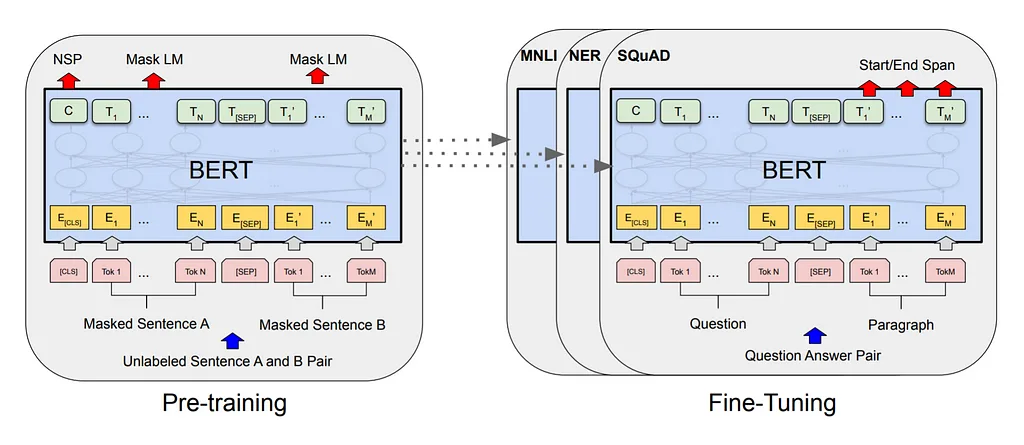

# `KTRAIN`

ktrain is a lightweight wrapper for the deep learning library TensorFlow Keras (and other libraries) to help build, train, and deploy neural networks and other machine learning models. Inspired by ML framework extensions like fastai and ludwig, it is designed to make deep learning and AI more accessible and easier to apply for both newcomers and experienced practitioners.

## Key Points to Remember

- BERT is basically a trained Transformer Encoder stack, with twelve in the Base version, and twenty-four in the Large version, compared to 6 encoder layers in the original Transformer.
- BERT encoders have larger feedforward networks (768 and 1024 nodes in Base and Large respectively) and more attention heads (12 and 16 respectively). BERT was trained on Wikipedia and Book Corpus, a dataset containing +10,000 books of different genres.

# Real or Not? Disaster Tweets Classifications

In [1]:
import pandas as pd
import numpy as np

import re
import string
import os

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

plt.style.use('ggplot')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from tensorflow.keras.optimizers import Adam

# Download Data

In [2]:
tweet = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/twitter-disaster-prediction-dataset/master/train.csv')

In [ ]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
tweet.shape

(7613, 5)

In [ ]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


# Exploratory Data Analysis

### Target Class Distribution

In [4]:
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi'] = 80

Text(0.5, 1.0, 'Real or Not Real Disaster Tweet')

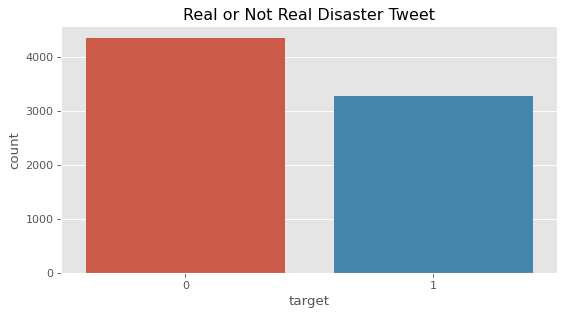

In [10]:
sns.countplot(x='target', data=tweet)
plt.title('Real or Not Real Disaster Tweet')


In [11]:
tweet['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

<Axes: ylabel='target'>

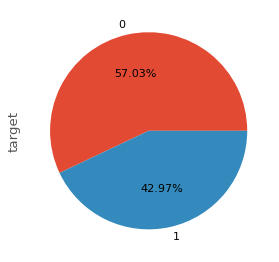

In [12]:
tweet['target'].value_counts().plot.pie(autopct='%1.2f%%')

### Number of Characters Distribution in Tweets

In [13]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-qj3dscyq
  Running command git clone --filter=blob:none --quiet https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-qj3dscyq
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie.git to commit 96bf02872d9756f29d6cddb8aafaedcd2a39bbb4
  Preparing metadata (setup.py) ... done
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=7603 sha256=25b383a900602486f3039d6c484b0b877bca175004d7d489670d03ea668f7fd2
  Stored in directory: /tmp/pip-ephem-wheel-cache-79mqav3p/wheels/5c/94/34/99d5ff65e88b8d9a6c5e8d8652f2311d87790a61a1b7466e21
Successfully built preprocess-kgptalkie


In [14]:
import preprocess_kgptalkie as kgp

In [15]:
tweet = kgp.get_basic_features(tweet)

In [ ]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0


<ipython-input-16-72f162dc66a6>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tweet['char_counts'])


<Axes: xlabel='char_counts', ylabel='Density'>

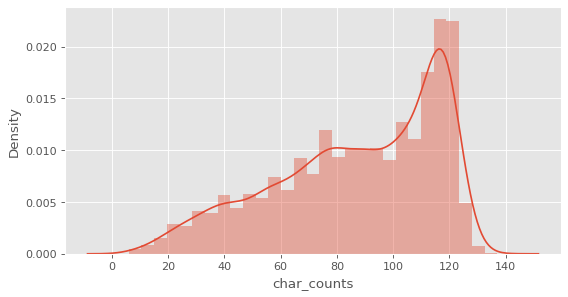

In [16]:
sns.distplot(tweet['char_counts'])

<ipython-input-17-7433aa2a83b9>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweet['char_counts'], shade=True)


<Axes: xlabel='char_counts', ylabel='Density'>

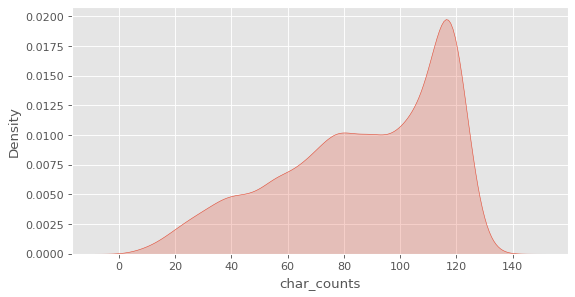

In [17]:
sns.kdeplot(tweet['char_counts'], shade=True)

<ipython-input-18-4c013d23f0f8>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweet[tweet['target']==1]['char_counts'], shade=True, color='red')
<ipython-input-18-4c013d23f0f8>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweet[tweet['target']==0]['char_counts'], shade=True, color='blue')


<Axes: xlabel='char_counts', ylabel='Density'>

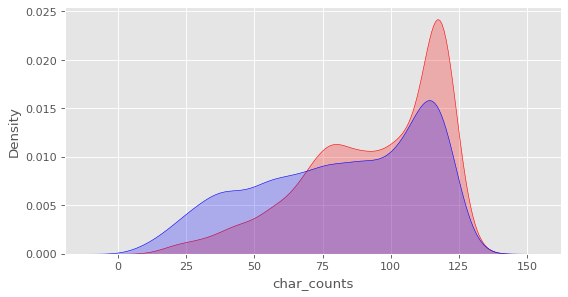

In [18]:
sns.kdeplot(tweet[tweet['target']==1]['char_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['char_counts'], shade=True, color='blue')

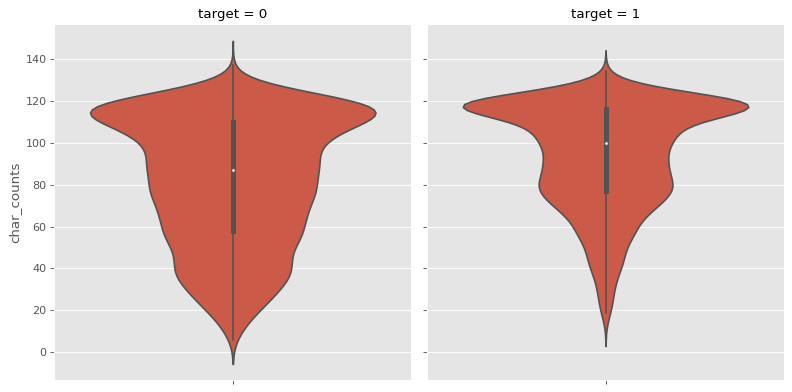

In [19]:
sns.catplot(y='char_counts', data=tweet, kind='violin', col='target')

### Number of Words, Average Words Length, and Stop words Distribution in Tweets

<ipython-input-20-48b4fde55523>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweet[tweet['target']==1]['word_counts'], shade=True, color='red')
<ipython-input-20-48b4fde55523>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweet[tweet['target']==0]['word_counts'], shade=True, color='magenta')


<Axes: xlabel='word_counts', ylabel='Density'>

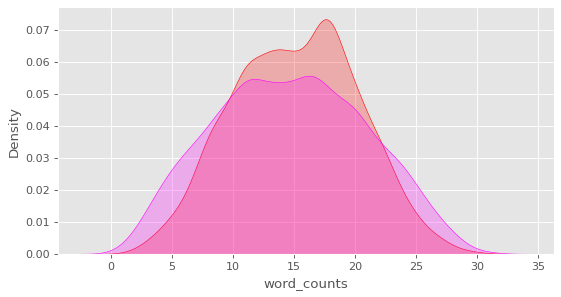

In [20]:
sns.kdeplot(tweet[tweet['target']==1]['word_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['word_counts'], shade=True, color='magenta')


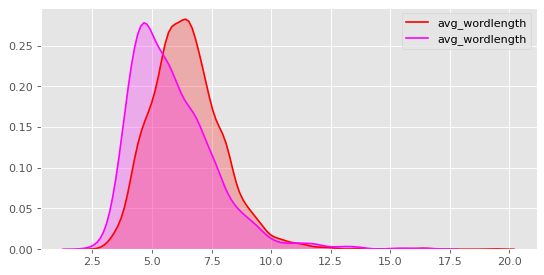

In [ ]:
sns.kdeplot(tweet[tweet['target']==1]['avg_wordlength'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['avg_wordlength'], shade=True, color='magenta')


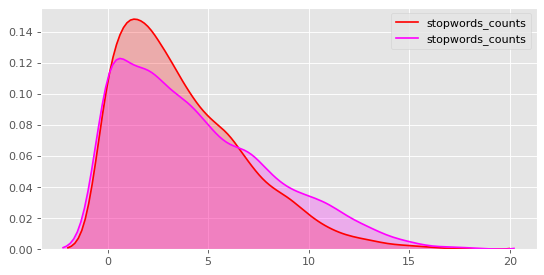

In [ ]:
sns.kdeplot(tweet[tweet['target']==1]['stopwords_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['stopwords_counts'], shade=True, color='magenta')


In [43]:
tweet.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'char_counts',
       'word_counts', 'avg_wordlength', 'stopwords_counts', 'hashtag_counts',
       'mentions_counts', 'digits_counts', 'uppercase_counts'],
      dtype='object')

### Most and Least Common Words

In [21]:
freqs = kgp.get_word_freqs(tweet, 'text')

In [22]:
top20 = freqs[100:120]

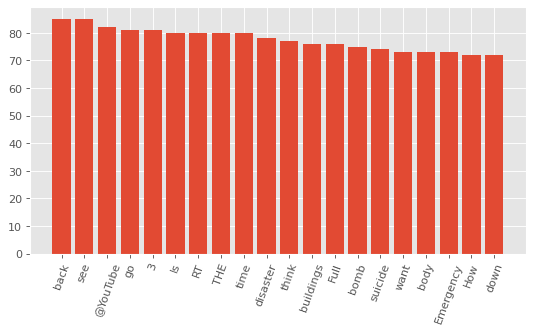

In [23]:
plt.bar(top20.index, top20.values)
plt.xticks(rotation=70)
plt.show()

In [24]:
least20 = freqs[-20:]
least20

http://t.co/JD7rIK7fX0     1
ft.åÊM.O.P.                1
http://t.co/ZDTz3RbS6w     1
'Detonate.'                1
@ApolloBrown's             1
PLAY                       1
missed.                    1
detonate&amp;Shots         1
succeed                    1
marines                    1
@BBCTalkback               1
@rfcgeom66                 1
@tomfromireland            1
@SourMashNumber7           1
#FIYA!                     1
https://t.co/NlJVP3Vfyz    1
(Ft.                       1
Dix                        1
bandolier                  1
http://t.co/YmY4rSkQ3d     1
dtype: int64

In [44]:
bigram = kgp.get_ngram(tweet, 'text', ngram_range=2)

In [45]:
bigram[-20:]

[('02 httpt', 19),
 ('015025 utc20150806', 18),
 ('015025 coordinated', 17),
 ('012624 utc20150805', 16),
 ('012032 greenwich', 15),
 ('0106 bmw', 14),
 ('010401 utc20150805', 13),
 ('0104 coordinated', 12),
 ('010217 okinawa', 11),
 ('010156 okinawa', 10),
 ('01 coordinated', 9),
 ('00end date', 8),
 ('005225 utc20150805', 7),
 ('0025 we', 6),
 ('0016 utc20150805', 5),
 ('0011 coordinated', 4),
 ('00 thread', 3),
 ('00 in', 2),
 ('00 httpt', 1),
 ('00 bestseller', 0)]

### One-Shot Data Cleaning

In [46]:
def get_clean(x):
    x = str(x).lower().replace('\\', ' ').replace('_', ' ').replace('.', ' ')
    x = kgp.cont_exp(x)
    x = kgp.remove_emails(x)
    x = kgp.remove_urls(x)
    x = kgp.remove_html_tags(x)
    x = kgp.remove_rt(x)
    x = kgp.remove_accented_chars(x)
    x = kgp.remove_special_chars(x)
    x = kgp.remove_dups_char(x)
    return x

In [47]:
tweet['text'] = tweet['text'].apply(lambda x: get_clean(x))

In [29]:
tweet.head()['text']

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    130 people receive wildfires evacuation orders...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [31]:
# kgp.get_ngram(tweet, 'text', ngram_range=2)

### Disaster Words Visualization with Word Cloud



In [32]:
real = kgp.get_word_freqs(tweet[tweet['target']==1], 'text')
real = ' '.join(real.index)
real

'httpt the in of a to and is on for i at by from it that with not you after this fire are was as have my news httpst over up more via disaster an were be people california suicide has no police who but when been killed like do 2 will just hiroshima than so out fires storm crash families we train now about into emergency s your buildings bomb there all what two mh370 attack am nuclear they wildfire video accident get new one bombing how prime minister northern burning legionnaires dead me bomber homes some if car war still atomic obama he fatal years off may us collapse forest retweet city watch debris malaysia first today 1 japan or man latest mass severe near water had earthquake before those confirmed found oil would down 70 spill floods army world home under warning 4 could injured wreckage weather derailment outbreak 3 evacuation being saudi thunderstorm migrants 40 our old flood missing flooding can during say investigators their time bridge back mosque death suspect state her cha

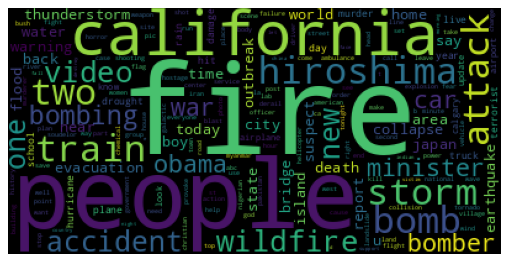

In [33]:
word_cloud = WordCloud(max_font_size=100).generate(real)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

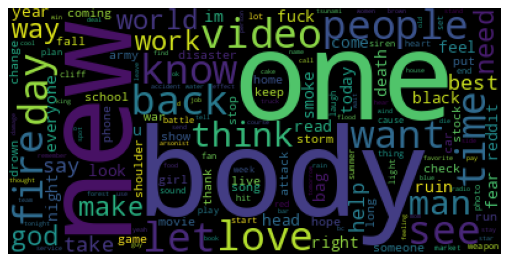

In [34]:
# not real plot

nreal = kgp.get_word_freqs(tweet[tweet['target']==0], 'text')
nreal = ' '.join(nreal.index)
word_cloud = WordCloud(max_font_size=100).generate(nreal)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

## Classification with TFIDF and SVM


In [35]:
text = tweet['text']
y = tweet['target']

In [36]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(text)

In [37]:
X.shape

(7613, 22545)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [39]:
def run_SVM(clf, X_train, X_test, y_train, y_test):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  print()
  print('Classification Report')
  print(classification_report(y_test, y_pred))

In [40]:
from sklearn.svm import LinearSVC

In [42]:
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       869
           1       0.83      0.69      0.75       654

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



## Classification with `Word2Vec` and SVM


In [48]:
!python -m spacy download en_core_web_lg

2023-11-27 15:21:40.798907: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 15:21:40.798973: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 15:21:40.799015: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-27 15:21:42.216628: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 3.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [49]:
import spacy
import en_core_web_lg

In [50]:
nlp = en_core_web_lg.load()

In [51]:
x = 'cat dog'
doc = nlp(x)

In [52]:
doc.vector.shape

(300,)

In [53]:
def get_vec(x):
  doc = nlp(x)
  vec = doc.vector
  return vec

In [54]:
tweet['vec'] = tweet['text'].apply(lambda x: get_vec(x))

In [55]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,vec
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,57,13,4.384615,6,1,0,0,1,"[-0.8476947, 0.8888447, -3.10391, 0.090650745,..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,32,7,4.571429,0,0,0,1,0,"[-0.35491997, -1.5415528, -2.0926642, -0.49523..."
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,112,22,5.090909,9,0,0,1,0,"[-2.8959212, 0.6998072, -2.5640087, 1.2561336,..."
3,6,NaN,NaN,130 people receive wildfires evacuation orders...,1,57,8,7.125000,1,1,0,1,0,"[-2.3889112, -0.6061475, -2.453201, 1.5150287,..."
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,72,16,4.500000,6,2,0,0,0,"[-0.8628482, -0.2587669, -2.5594664, 0.3031685..."


In [56]:
X = tweet['vec'].to_numpy()
X = X.reshape(-1, 1)

In [57]:
X.shape

(7613, 1)

In [58]:
X = np.concatenate(np.concatenate(X, axis=0), axis=0).reshape(-1, 300)

In [59]:
X.shape

(7613, 300)

In [60]:
y = tweet['target']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [62]:
%%time
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.68      0.76       869
           1       0.66      0.84      0.74       654

    accuracy                           0.75      1523
   macro avg       0.76      0.76      0.75      1523
weighted avg       0.77      0.75      0.75      1523

CPU times: user 6.39 s, sys: 41.6 ms, total: 6.43 s
Wall time: 6.48 s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Word Embeddings and Classification with Deep Learning


In [63]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [64]:
text

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3       130 people receive wildfires evacuation orders...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    aria ahrary thetawniest the out of control wil...
7610    m1 94 0104 coordinated universal time5km s of ...
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: text, Length: 7613, dtype: object

In [65]:
token = Tokenizer()
token.fit_on_texts(text)

In [66]:
vocab_size = len(token.word_index) + 1
vocab_size

22581

In [67]:
print(token.word_index)

{'httpt': 1, 'the': 2, 'a': 3, 'in': 4, 'to': 5, 'of': 6, 'i': 7, 'and': 8, 'is': 9, 'you': 10, 'for': 11, 'on': 12, 'it': 13, 'my': 14, 'not': 15, 'that': 16, 'with': 17, 'at': 18, 'by': 19, 'this': 20, 'have': 21, 'are': 22, 'from': 23, 'be': 24, 'was': 25, 'httpst': 26, 'do': 27, 'like': 28, 'as': 29, 'out': 30, 'am': 31, 'so': 32, 'your': 33, 'up': 34, 'me': 35, 'just': 36, 'but': 37, 'will': 38, 'after': 39, 'has': 40, 'all': 41, 'no': 42, 'fire': 43, 'an': 44, 'when': 45, 'if': 46, 'he': 47, 'new': 48, 'we': 49, 'get': 50, 'they': 51, 'now': 52, 'about': 53, 'via': 54, 'more': 55, 'people': 56, 'what': 57, 'or': 58, 'how': 59, 'one': 60, 'been': 61, 'there': 62, '2': 63, 'over': 64, 'news': 65, 'would': 66, 'who': 67, 'into': 68, 'were': 69, 'video': 70, 'can': 71, 'emergency': 72, 'disaster': 73, 'us': 74, 'police': 75, 'than': 76, 'off': 77, 'her': 78, 'some': 79, 'still': 80, 'his': 81, 'body': 82, 'back': 83, 'time': 84, 'burning': 85, 'california': 86, 'crash': 87, 'know': 8

In [68]:
encoded_text = token.texts_to_sequences(text)

In [69]:
print(encoded_text)

[[109, 4491, 22, 2, 868, 6, 20, 246, 129, 1681, 4492, 74, 41], [186, 43, 223, 763, 6792, 6793, 1328], [41, 1682, 1435, 5, 2062, 4, 655, 22, 125, 6794, 19, 1683, 42, 438, 253, 58, 2062, 4, 655, 1329, 22, 1054], [2809, 56, 4493, 1330, 253, 1329, 4, 86], [36, 93, 1159, 20, 314, 23, 6795, 2063, 29, 261, 23, 1330, 6796, 68, 3, 189], [2810, 391, 86, 1554, 793, 829, 4, 637, 6797, 534, 5, 1106, 372, 43, 4494, 1330], [224, 73, 830, 282, 1160, 831, 247, 6, 1862, 4, 6798, 999, 2344, 1555], [7, 31, 12, 225, 6, 2, 1863, 8, 7, 71, 103, 3, 43, 4, 2, 4495], [62, 9, 44, 72, 253, 1237, 52, 4, 2, 585, 832, 2, 703], [7, 31, 2345, 16, 2, 489, 9, 240, 5, 109, 354], [586, 56, 611, 23, 2, 283, 467, 32, 612], [833, 613, 2811, 9, 217, 2812, 3467, 656, 3, 657, 7, 199, 4, 613, 2811, 57, 31, 7, 301, 27, 57, 31, 7, 301, 27, 6799, 247], [2813, 247, 2064, 6800, 2811, 1436, 58, 1864, 614, 7, 21, 735, 3468], [224, 4, 4496, 912, 49, 1684, 4496], [241, 5, 189, 392, 12, 2346, 4, 4497, 126, 87, 355], [638, 34, 96], [7, 110

In [70]:
max_length = 40
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')

In [71]:
print(X)

[[ 109 4491   22 ...    0    0    0]
 [ 186   43  223 ...    0    0    0]
 [  41 1682 1435 ...    0    0    0]
 ...
 [2709 2295 4483 ...    0    0    0]
 [  75 1092   39 ...    0    0    0]
 [   2  206   55 ...    0    0    0]]


In [72]:
X.shape

(7613, 40)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
%%time
# clf = LinearSVC()
# run_SVM(clf, X_train, X_test, y_train, y_test)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.25 µs


In [75]:
vec_size = 100

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

In [76]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 100)           2258100   
                                                                 
 conv1d (Conv1D)             (None, 39, 32)            6432      
                                                                 
 max_pooling1d (MaxPooling1  (None, 19, 32)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 19, 32)            0         
                                                                 
 dense (Dense)               (None, 19, 32)            1056      
                                                                 
 dropout_1 (Dropout)         (None, 19, 32)            0         
                                                        

In [77]:
%%time
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
191/191 [==============================] - 27s 77ms/step - loss: 0.6779 - accuracy: 0.5798 - val_loss: 0.6529 - val_accuracy: 0.6973
Epoch 2/5
191/191 [==============================] - 5s 28ms/step - loss: 0.5333 - accuracy: 0.7512 - val_loss: 0.4753 - val_accuracy: 0.7951
Epoch 3/5
191/191 [==============================] - 2s 10ms/step - loss: 0.3574 - accuracy: 0.8557 - val_loss: 0.4610 - val_accuracy: 0.7873
Epoch 4/5
191/191 [==============================] - 2s 10ms/step - loss: 0.2366 - accuracy: 0.9125 - val_loss: 0.4915 - val_accuracy: 0.7669
Epoch 5/5
191/191 [==============================] - 2s 10ms/step - loss: 0.1496 - accuracy: 0.9452 - val_loss: 0.5431 - val_accuracy: 0.7603
CPU times: user 23.1 s, sys: 1.53 s, total: 24.6 s
Wall time: 38 s


In [78]:
def get_encoded(x):
  x = get_clean(x)
  x = token.texts_to_sequences([x])
  x = pad_sequences(x, maxlen=max_length, padding='post')
  return x

In [95]:
x = 'forest fire near la ronge sask canada '
vec = get_encoded(x)

In [96]:
vec

array([[ 186,   43,  223,  763, 6792, 6793, 1328,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]], dtype=int32)

In [97]:
np.argmax(model.predict(vec), axis = -1)

1/1 [==============================] - 0s 17ms/step


array([0])

# BERT Model Building and Training

In [88]:
!pip install ktrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 25.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 67.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 36.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ktrain: filename=ktrain-0.39.0-py3-none-any.whl size=25319738 sha256=9e9b88509bb227262fa89e0ae027eb552cac7361f3b62746ebb77f58f9c00a94
  Stored in directory: /root/.cache/pip/wheels/98/fd/0a/ef6252223f3d2

In [89]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,vec
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,57,13,4.384615,6,1,0,0,1,"[-0.8476947, 0.8888447, -3.10391, 0.090650745,..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,32,7,4.571429,0,0,0,1,0,"[-0.35491997, -1.5415528, -2.0926642, -0.49523..."
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,112,22,5.090909,9,0,0,1,0,"[-2.8959212, 0.6998072, -2.5640087, 1.2561336,..."
3,6,NaN,NaN,130 people receive wildfires evacuation orders...,1,57,8,7.125000,1,1,0,1,0,"[-2.3889112, -0.6061475, -2.453201, 1.5150287,..."
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,72,16,4.500000,6,2,0,0,0,"[-0.8628482, -0.2587669, -2.5594664, 0.3031685..."


In [90]:
from ktrain import text
import ktrain

In [91]:
(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(train_df=tweet, text_column='text', label_columns='target', maxlen=40, preprocess_mode='bert')

['not_target', 'target']
      not_target  target
4284         1.0     0.0
4371         0.0     1.0
5293         0.0     1.0
6375         0.0     1.0
7461         0.0     1.0
['not_target', 'target']
      not_target  target
7            0.0     1.0
906          1.0     0.0
6642         0.0     1.0
5009         1.0     0.0
3721         1.0     0.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [98]:
model = text.text_classifier(name='bert', train_data=(X_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 40


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


done.


In [99]:
learner = ktrain.get_learner(model=model, train_data=(X_train, y_train), val_data=(X_test, y_test), batch_size=64)

In [100]:
learner.fit_onecycle(lr = 2e-5, epochs=1)



begin training using onecycle policy with max lr of 2e-05...
108/108 [==============================] - 84s 571ms/step - loss: 0.4937 - accuracy: 0.7597 - val_loss: 0.3798 - val_accuracy: 0.8556


In [101]:
learner.fit_onecycle(lr = 2e-5, epochs=3)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
108/108 [==============================] - 58s 535ms/step - loss: 0.3590 - accuracy: 0.8526 - val_loss: 0.3966 - val_accuracy: 0.8386
Epoch 2/3
108/108 [==============================] - 57s 531ms/step - loss: 0.3261 - accuracy: 0.8702 - val_loss: 0.3827 - val_accuracy: 0.8451
Epoch 3/3
108/108 [==============================] - 57s 527ms/step - loss: 0.2341 - accuracy: 0.9118 - val_loss: 0.4345 - val_accuracy: 0.8307


In [102]:
learner = ktrain.get_learner(model=model, train_data=(X_train, y_train), val_data=(X_test, y_test), batch_size=64)
learner.fit_onecycle(lr = 2e-4, epochs=3)



begin training using onecycle policy with max lr of 0.0002...
Epoch 1/3
108/108 [==============================] - 62s 570ms/step - loss: 0.2983 - accuracy: 0.8860 - val_loss: 0.7583 - val_accuracy: 0.7559
Epoch 2/3
108/108 [==============================] - 57s 532ms/step - loss: 0.3388 - accuracy: 0.8664 - val_loss: 0.3828 - val_accuracy: 0.8399
Epoch 3/3
108/108 [==============================] - 57s 527ms/step - loss: 0.1714 - accuracy: 0.9396 - val_loss: 0.4501 - val_accuracy: 0.8478


In [ ]:
# find out best learning rate?
# learner.lr_find()
# learner.lr_plot()

# it may take days or many days to find out.

In [104]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [105]:
data = ['i met you today by accident', 'i got today car accident, i am injured']

In [106]:
predictor.predict(data, return_proba=True)

array([[0.9710324 , 0.02896758],
       [0.01417315, 0.9858269 ]], dtype=float32)

In [107]:
predictor.predict(data[1])

'target'

In [108]:
classes = predictor.get_classes()

In [109]:
data

['i met you today by accident', 'i got today car accident, i am injured']

In [110]:
y_pred = predictor.predict(data[1])
classes.index(y_pred)

1

In [111]:
y_train

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

# Other Resources
|  ML Course | Description |
|:---|:---|
| [**Data Visualization in Python Masterclass™: Beginners to Pro**](https://bit.ly/udemy95off_kgptalkie) |  Learn to build Machine Learning and Deep Learning models using Python and its libraries like Scikit-Learn, Keras, and TensorFlow. |
| [**Python for Machine Learning: A Step-by-Step Guide**](https://bit.ly/ml-ds-project) | Learn to build Machine Learning and Deep Learning models using Python and its libraries like Scikit-Learn, Keras, and TensorFlow. |
| [**Python for Linear Regression in Machine Learning**](https://bit.ly/regression-python) | Learn to build Linear Regression models using Python and its libraries like Scikit-Learn. |
| [**Introduction to Spacy 3 for Natural Language Processing**](https://bit.ly/spacy-intro) | Learn to build Natural Language Processing models using Python and its libraries like Spacy. |
| [**Advanced Machine Learning and Deep Learning Projects**](https://bit.ly/kgptalkie_ml_projects) | Learn to build Advanced Machine Learning and Deep Learning models using Python and transformer models like BERT, GPT-2, and XLNet. |
| [**Natural Language Processing in Python for Beginners**](https://bit.ly/intro_nlp) | Learn to build Natural Language Processing Projects using Spacy, NLTK, and Gensim, and transformer models like BERT, GPT-2, and XLNet. |
| [**Deployment of Machine Learning Models in Production in Python**](https://bit.ly/bert_nlp) |  Learn to deploy Machine Learning and Deep Learning models using Python and its libraries like Flask, Streamlit, and NGINX. |
| [**R 4.0 Programming for Data Science - Beginners to Pro**](https://bit.ly/r4-ml) | Learn to build Machine Learning and Deep Learning models using R and its libraries like caret, tidyverse, and keras. |
